In [1]:
# !pip install pandas
# !pip install seaborn
# !pip install matplotlib
# !pip install openpyxl
# !pip install humanize
# !pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import humanize
from IPython.display import display
from dawithscm.utils import feature_importance, makeDir, plotpdf, coolReshape, distributionValue, plotMetric, convertToPercentage
from dawithscm.prediction import prediction_regression

2022-11-29 05:13:47.722242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Data Exploration

The given dataset is a dataset of the power consumption of a programmable CNC milling machine with the corresponding process features. A row represents a process with its properties, timestamps and power consumption. During a process the tool can be changed multiple times. You can see en example of the process here https://www.youtube.com/watch?v=PK8MLLqH7mU

Target
- processing_time
- average_power_consumption

In [3]:
df_cnc = pd.read_excel("data/CNCmachine/CNC-Milling Machine_Production data.xlsx")
display(df_cnc.head())
print(f"The number of row: {df_cnc.shape[0]}")
print(f"The number of column: {df_cnc.shape[1]}")

start_time    end_time  processing_time  average_power_consumption  \
0  1649055030  1649055950              920          23582271739130432   
1  1649056780  1649057100              320                   25380875   
2  1649237400  1649237800              400          26181281407035176   
3  1649243450  1649243800              350           3386402857142857   
4  1649243850  1649244200              350           3306637142857143   

   number_of_missing_datapoints  raw_volume  number_of_lines_of_code  \
0                             0   136659600                     5809   
1                             0   136659600                      462   
2                            10      420000                      234   
3                             0      420000                      234   
4                             0      420000                      234   

   number_tool_changes  \
0                    5   
1                    4   
2                    2   
3                    2   
4                    2   

   number_of_travels_to_machine_zero_point_in_rapid_traverse  \
0                                                 11           
1                                                 13           
2                                                  5           
3                                                  5           
4                                                  5           

   number_axis_rotations     weighted_speed  weighted_tool_diameter  \
0                      6  79438718501135840       15894074969770256   
1                      7  78655669160619040        1148868778280543   
2                      3   7269291649018721       12126168224299066   
3                      3   7269291649018721       12126168224299066   
4                      3   7269291649018721       12126168224299066   

   weighted_cutting_length  weighted_number_of_cutting_edges  \
0         4343264812575575                  4010019001554673   
1        28009049773755656                  4208144796380091   
2         5289719626168225                  4107476635514018   
3         5289719626168225                  4107476635514018   
4         5289719626168225                  4107476635514018   

   weighted_cutting_speed  weighted_feed_per_tooth  weighted_feedrate  
0        3977633442736224        11971497667991020  36788711932266936  
1       28494117647058824         5610369532428357    182943409943081  
2        1584158878504673         7263715661992795  20428703826796160  
3        1584158878504673         7263715661992795  20428703826796160  
4        1584158878504673         7263715661992795  20428703826796160

The number of row: 220
The number of column: 17


In [4]:
df_cnc.describe()

start_time      end_time  processing_time  average_power_consumption  \
count  2.200000e+02  2.200000e+02       220.000000               2.200000e+02   
mean   1.654939e+09  1.654940e+09      1022.886364               1.662605e+16   
std    2.215448e+06  2.215309e+06      1457.893633               1.396877e+16   
min    1.649055e+09  1.649056e+09       100.000000               2.222300e+04   
25%    1.653306e+09  1.653307e+09       292.500000               2.316632e+15   
50%    1.656321e+09  1.656321e+09       480.000000               1.945973e+16   
75%    1.656419e+09  1.656420e+09       912.500000               2.972326e+16   
max    1.657169e+09  1.657169e+09      6920.000000               4.229679e+16   

       number_of_missing_datapoints    raw_volume  number_of_lines_of_code  \
count                    220.000000  2.200000e+02               220.000000   
mean                      19.272727  8.069418e+07              6895.327273   
std                       33.765484  6.621539e+07              9597.106987   
min                        0.000000  2.492280e+05                86.000000   
25%                        0.000000  8.751360e+05               313.000000   
50%                        0.000000  1.366596e+08               968.500000   
75%                       20.000000  1.366596e+08             13447.000000   
max                      210.000000  1.366596e+08             44441.000000   

       number_tool_changes  \
count           220.000000   
mean              5.763636   
std               4.731952   
min               1.000000   
25%               2.000000   
50%               4.000000   
75%               6.250000   
max              18.000000   

       number_of_travels_to_machine_zero_point_in_rapid_traverse  \
count                                         220.000000           
mean                                           48.781818           
std                                            72.534971           
min                                             3.000000           
25%                                             7.000000           
50%                                            21.000000           
75%                                            63.000000           
max                                           263.000000           

       number_axis_rotations  weighted_speed  weighted_tool_diameter  \
count             220.000000    2.200000e+02            2.200000e+02   
mean               24.890909    9.168552e+15            1.110948e+16   
std                36.267486    1.029301e+16            5.188261e+15   
min                 2.000000    1.098347e+14            8.000000e+01   
25%                 4.000000    7.083711e+15            6.201614e+15   
50%                11.000000    7.779717e+15            1.212617e+16   
75%                32.000000    8.008454e+15            1.550609e+16   
max               132.000000    7.943872e+16            1.913700e+16   

       weighted_cutting_length  weighted_number_of_cutting_edges  \
count             2.200000e+02                      2.200000e+02   
mean              1.964992e+16                      1.020974e+16   
std               1.418189e+16                      1.395040e+16   
min               2.000000e+02                      2.000000e+01   
25%               5.289720e+15                      4.029052e+15   
50%               2.229508e+16                      4.154639e+15   
75%               2.851920e+16                      5.646341e+15   
max               4.210844e+16                      4.894198e+16   

       weighted_cutting_speed  weighted_feed_per_tooth  weighted_feedrate  
count            2.200000e+02             2.200000e+02       2.200000e+02  
mean             1.211113e+16             1.232763e+16       1.098923e+16  
std              1.445534e+16             1.390119e+16       1.048769e+16  
min              4.000000e+02             4.700000e+01       1.829434e+14  
25%              1.664277e+15             5.852345

# Data Preparation

In [5]:
def timeoftheday(df):
    if 5 < df.hour < 12:
        return 'morning'
    elif 11 < df.hour < 18:
        return 'afternoon'
    else: 
        return 'evening'

def workinghour(df):
    if 7 < df.hour < 18:
        return 'yes'
    else:
        return 'no'

In [6]:
df_cnc_temp = df_cnc
df_cnc["start_time_dt"] = df_cnc_temp["start_time"].apply(pd.Timestamp.fromtimestamp)
df_cnc["end_time_dt"] = df_cnc_temp["end_time"].apply(pd.Timestamp.fromtimestamp)

df_cnc["start_time_tod"] = df_cnc["start_time_dt"].apply(timeoftheday)
df_cnc["end_time_tod"] = df_cnc["end_time_dt"].apply(timeoftheday)
df_cnc["start_time_workinghr"] = df_cnc["start_time_dt"].apply(workinghour)
df_cnc["end_time_workinghr"] = df_cnc["end_time_dt"].apply(workinghour)
display(df_cnc.head())


start_time    end_time  processing_time  average_power_consumption  \
0  1649055030  1649055950              920          23582271739130432   
1  1649056780  1649057100              320                   25380875   
2  1649237400  1649237800              400          26181281407035176   
3  1649243450  1649243800              350           3386402857142857   
4  1649243850  1649244200              350           3306637142857143   

   number_of_missing_datapoints  raw_volume  number_of_lines_of_code  \
0                             0   136659600                     5809   
1                             0   136659600                      462   
2                            10      420000                      234   
3                             0      420000                      234   
4                             0      420000                      234   

   number_tool_changes  \
0                    5   
1                    4   
2                    2   
3                    2   
4                    2   

   number_of_travels_to_machine_zero_point_in_rapid_traverse  \
0                                                 11           
1                                                 13           
2                                                  5           
3                                                  5           
4                                                  5           

   number_axis_rotations  ...  weighted_number_of_cutting_edges  \
0                      6  ...                  4010019001554673   
1                      7  ...                  4208144796380091   
2                      3  ...                  4107476635514018   
3                      3  ...                  4107476635514018   
4                      3  ...                  4107476635514018   

   weighted_cutting_speed  weighted_feed_per_tooth  weighted_feedrate  \
0        3977633442736224        11971497667991020  36788711932266936   
1       28494117647058824         5610369532428357    182943409943081   
2        1584158878504673         7263715661992795  20428703826796160   
3        1584158878504673         7263715661992795  20428703826796160   
4        1584158878504673         7263715661992795  20428703826796160   

        start_time_dt         end_time_dt  start_time_tod end_time_tod  \
0 2022-04-04 08:50:30 2022-04-04 09:05:50         morning      morning   
1 2022-04-04 09:19:40 2022-04-04 09:25:00         morning      morning   
2 2022-04-06 11:30:00 2022-04-06 11:36:40         morning      morning   
3 2022-04-06 13:10:50 2022-04-06 13:16:40       afternoon    afternoon   
4 2022-04-06 13:17:30 2022-04-06 13:23:20       afternoon    afternoon   

  start_time_workinghr end_time_workinghr  
0                  yes                yes  
1                  yes                yes  
2                  yes                yes  
3                  yes                yes  
4                  yes                yes  

[5 rows x 23 columns]

# 2. Analysis

## 2.1 Check for Duplicates

In [7]:
#Check for duplicates

# Search for duplication rows from shipment_id
df_cnc_temp_dup = df_cnc_temp[["start_time", "end_time", "processing_time", "average_power_consumption", "number_of_missing_datapoints"]].loc[df_cnc_temp['start_time'].duplicated(), :]
display(df_cnc_temp_dup.head())
print(f"There are {len(df_cnc_temp_dup)} rows containg duplication in start_time column.")

Empty DataFrame
Columns: [start_time, end_time, processing_time, average_power_consumption, number_of_missing_datapoints]
Index: []

There are 0 rows containg duplication in start_time column.


## 2.2 Analyse start and end time and compare to processing_time

In [8]:
from sklearn.preprocessing import LabelEncoder

#Function to convert categorical data into numerical using label encoder
def labelEncoding(dataset, column):
    labelencoder = LabelEncoder()
    dataset[column] = labelencoder.fit_transform(dataset[column])
    return dataset

In [9]:
df_cnc_encoded = labelEncoding(df_cnc,'start_time_tod')
df_cnc_encoded = labelEncoding(df_cnc,'end_time_tod')

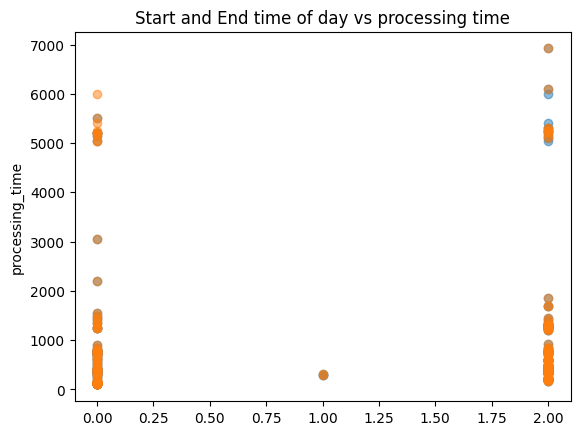

In [10]:
plt.title("Start and End time of day vs processing time")
plt.ylabel('processing_time')
plt.scatter(df_cnc['start_time_tod'], df_cnc['processing_time'], alpha=0.5)
plt.scatter(df_cnc['end_time_tod'], df_cnc['processing_time'], alpha=0.5)
plt.show()

## 2.3 Scatter plot

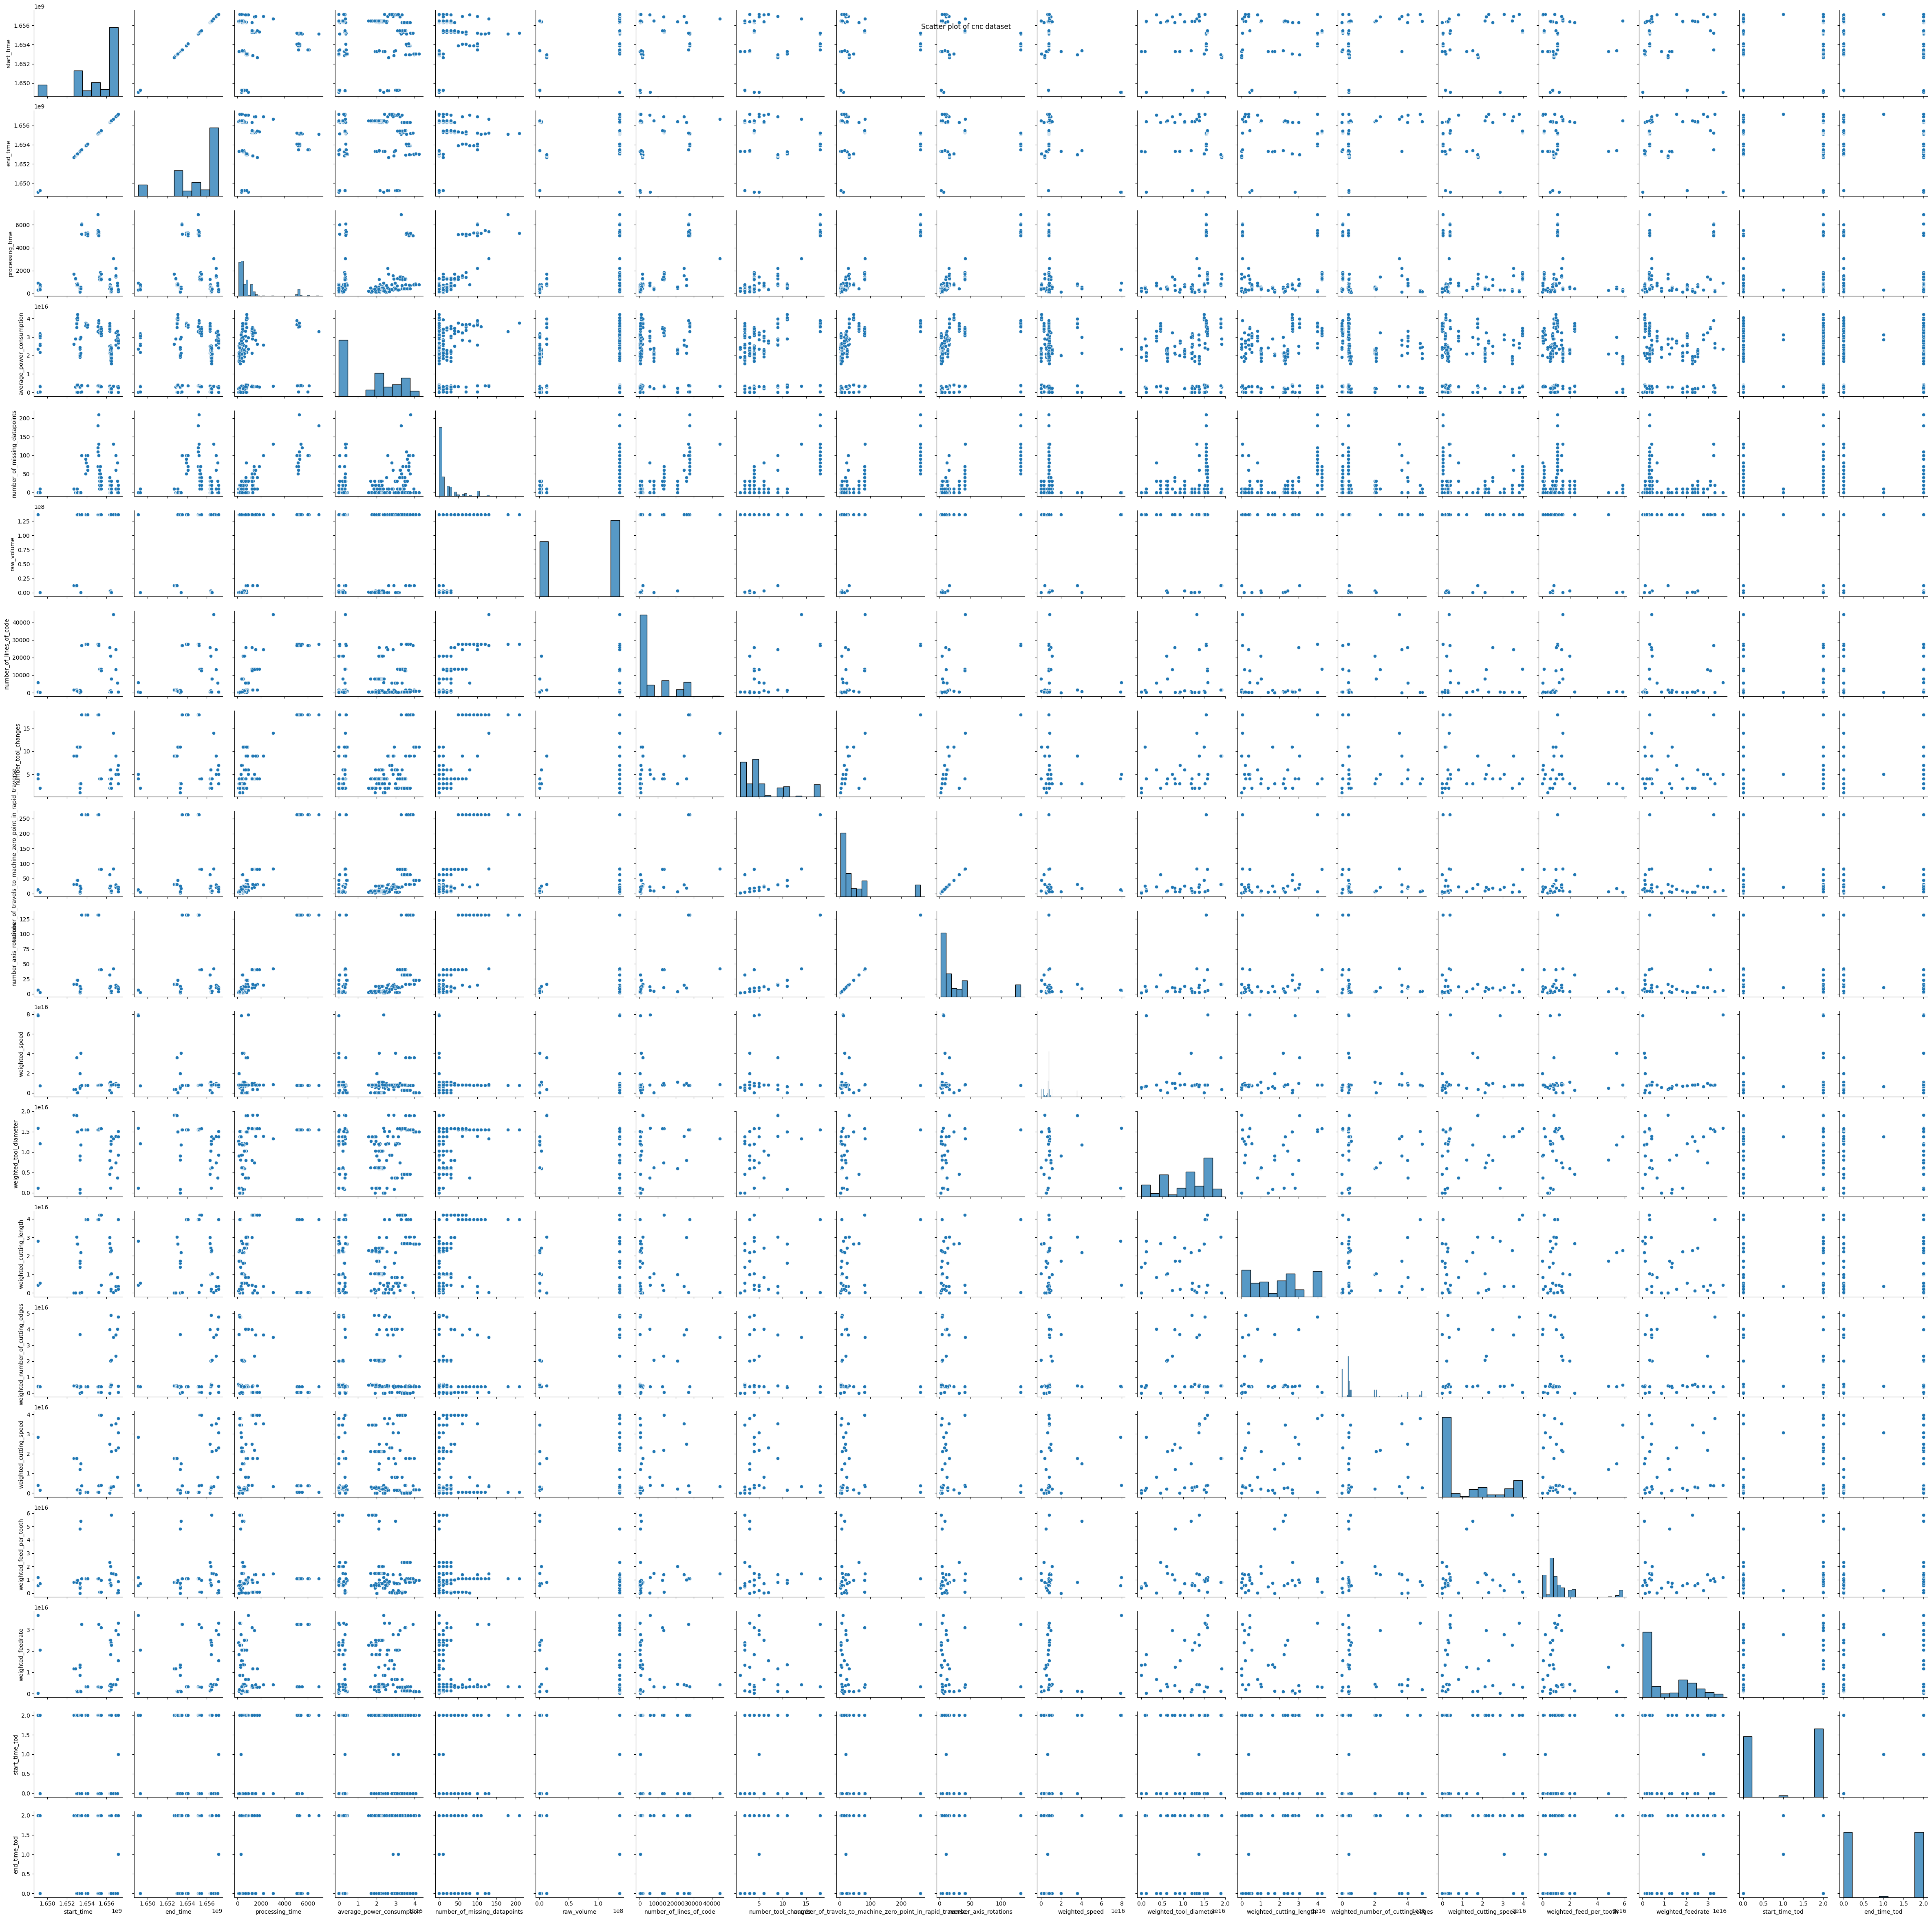

In [11]:
df_plot = df_cnc.copy()

g = sns.pairplot(df_plot)
g.fig.suptitle('Scatter plot of cnc dataset')
plt.tight_layout()
plt.show()

## 2.4 Correlation Matrix

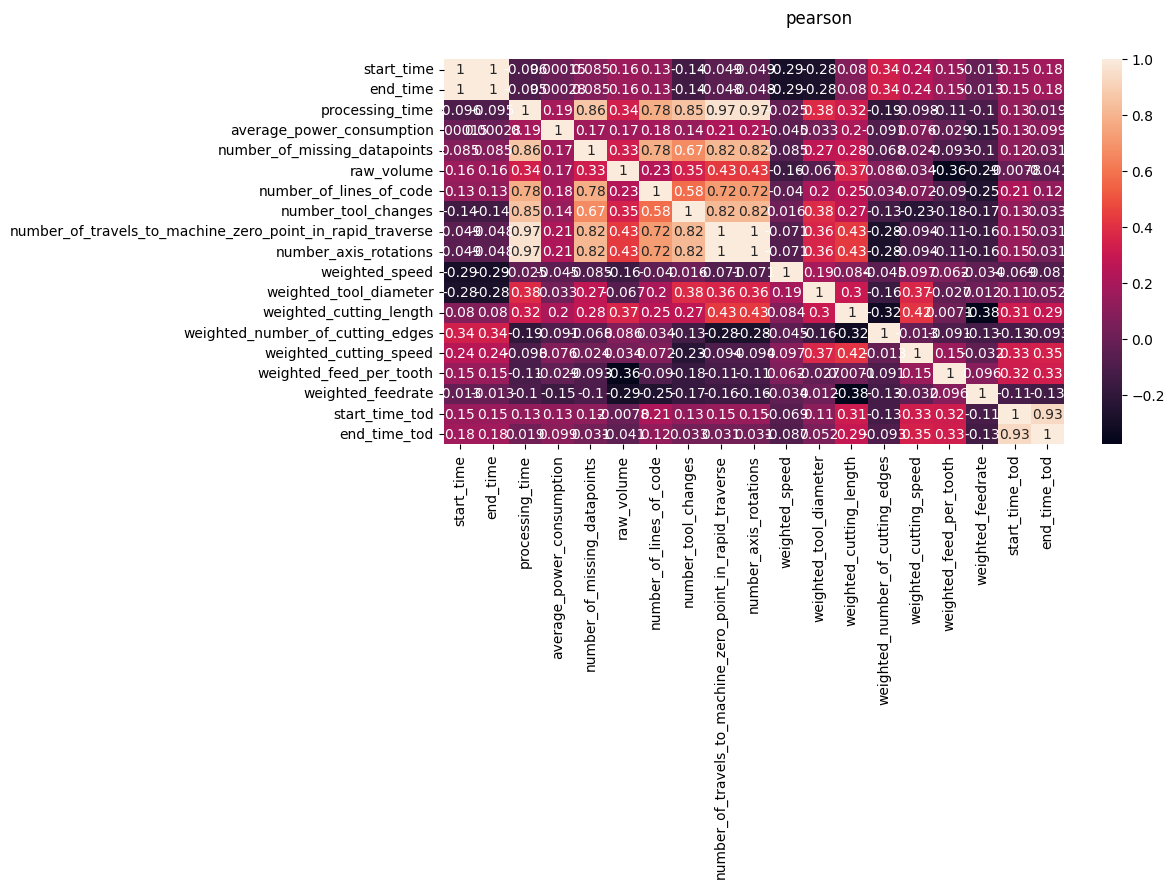

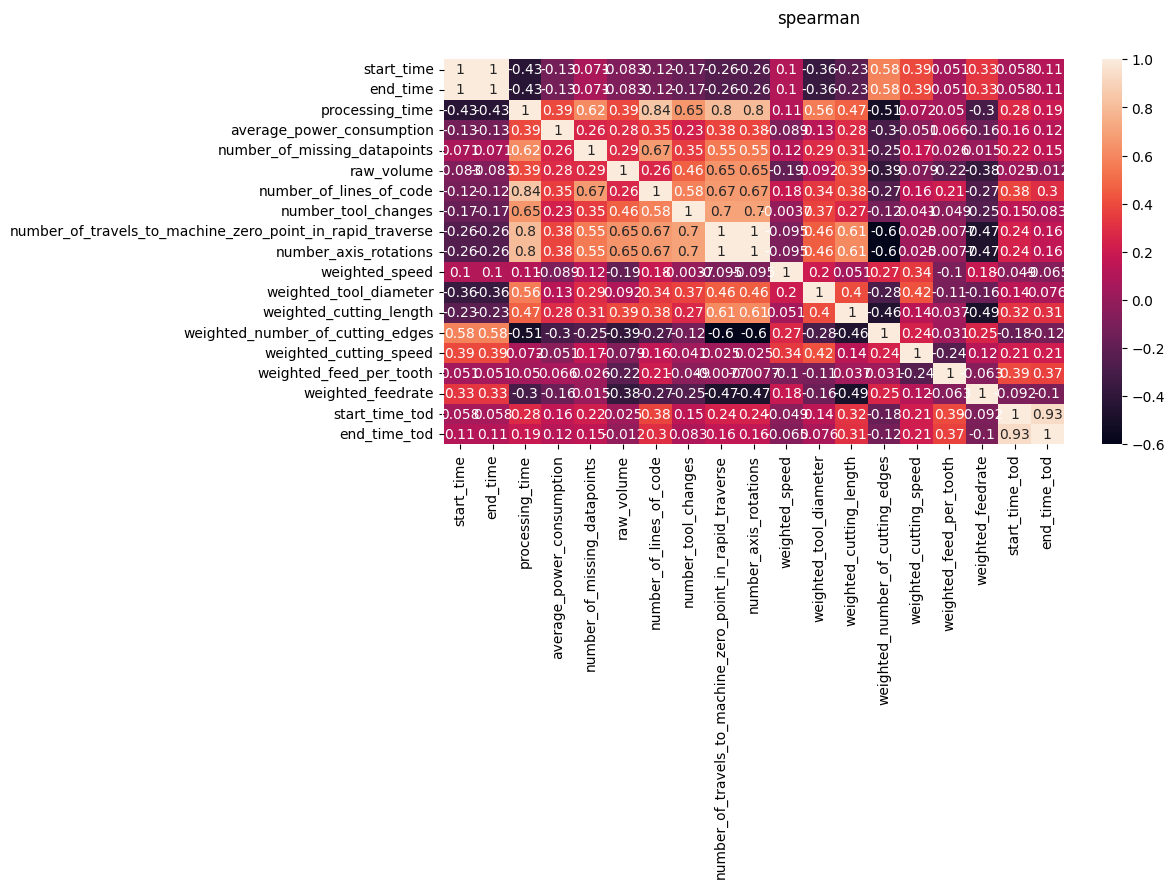

In [12]:
items = ['pearson', 'spearman']
for item in items:
    fig, axe = plt.subplots(figsize=(10,5))
    fig.suptitle(item)
    sns.heatmap(df_cnc.corr(method=item, numeric_only=True), annot=True)
    plt.show()


### 2.4.1 Correlation for processing_time

In [13]:
df_cnc.corr(method='pearson', numeric_only=True).sort_values('processing_time', ascending=False)['processing_time']

processing_time                                              1.000000
number_axis_rotations                                        0.966316
number_of_travels_to_machine_zero_point_in_rapid_traverse    0.966316
number_of_missing_datapoints                                 0.863548
number_tool_changes                                          0.853962
number_of_lines_of_code                                      0.784716
weighted_tool_diameter                                       0.381967
raw_volume                                                   0.336831
weighted_cutting_length                                      0.318705
average_power_consumption                                    0.188783
start_time_tod                                               0.134931
end_time_tod                                                 0.019479
weighted_speed                                              -0.025400
end_time                                                    -0.095305
start_time          

**processing_time** has very highly linear correlation with the following features.
- number_of_travels_to_machine_zero_point_in_rapid_traverse
- number_axis_rotations
- number_of_missing_datapoints
- number_tools_changes
- number_of_lines_of_code

In [14]:
df_cnc.corr(method='spearman', numeric_only=True).sort_values('processing_time', ascending=False)['processing_time']

processing_time                                              1.000000
number_of_lines_of_code                                      0.841590
number_axis_rotations                                        0.802062
number_of_travels_to_machine_zero_point_in_rapid_traverse    0.802062
number_tool_changes                                          0.652762
number_of_missing_datapoints                                 0.616476
weighted_tool_diameter                                       0.562307
weighted_cutting_length                                      0.473984
average_power_consumption                                    0.392470
raw_volume                                                   0.391840
start_time_tod                                               0.279518
end_time_tod                                                 0.188401
weighted_speed                                               0.107656
weighted_cutting_speed                                       0.072152
weighted_feed_per_to

By using spearman, most of the correlated features with **processing_time** are similar. However, there are some columns that has a monotonic relation with the target as below.
- weighted_tool_diameter
- weighted_number_of_cutting_edges
- weighted_feedrate

In conclusion, the following features might be features for **processing_time**
- number_of_travels_to_machine_zero_point_in_rapid_traverse
- number_axis_rotations
- number_of_missing_datapoints
- number_tools_changes
- number_of_lines_of_code
- weighted_tool_diameter
- weighted_number_of_cutting_edges
- weighted_feedrate

### 2.2.2 Correlation for average_power_consumption

In [15]:
df_cnc.corr(method='pearson', numeric_only=True).sort_values('average_power_consumption', ascending=False)['average_power_consumption']

average_power_consumption                                    1.000000
number_axis_rotations                                        0.212727
number_of_travels_to_machine_zero_point_in_rapid_traverse    0.212727
weighted_cutting_length                                      0.202067
processing_time                                              0.188783
number_of_lines_of_code                                      0.184588
raw_volume                                                   0.174706
number_of_missing_datapoints                                 0.167220
number_tool_changes                                          0.144057
start_time_tod                                               0.127780
end_time_tod                                                 0.099460
weighted_cutting_speed                                       0.075718
weighted_tool_diameter                                       0.032825
end_time                                                     0.000278
start_time          

Even though there is no highly correlated feature with **average_power_consumption** using linear function, the columns below are worth looking as a featrues for the target.
- number_of_travels_to_machine_zero_point_in_rapid_traverse
- number_axis_rotations
- weighted_cutting_length

In [16]:
df_cnc.corr(method='spearman', numeric_only=True).sort_values('average_power_consumption', ascending=False)['average_power_consumption']

average_power_consumption                                    1.000000
processing_time                                              0.392470
number_axis_rotations                                        0.379675
number_of_travels_to_machine_zero_point_in_rapid_traverse    0.379675
number_of_lines_of_code                                      0.352183
raw_volume                                                   0.284420
weighted_cutting_length                                      0.282016
number_of_missing_datapoints                                 0.257037
number_tool_changes                                          0.231078
start_time_tod                                               0.155756
weighted_tool_diameter                                       0.126745
end_time_tod                                                 0.117773
weighted_feed_per_tooth                                      0.066230
weighted_cutting_speed                                      -0.051061
weighted_speed      

As same as pearson there is also no highly correlated feature with **average_power_consumption** using monotonic function. However, there  some more columns that could be a candidate as features.
- processing_time
- number_of_lines_of_code
- weighted_number_of_cutting_edges

In conclusion, the following features might be features for **average_power_consumption**
- number_of_travels_to_machine_zero_point_in_rapid_traverse
- number_axis_rotations
- weighted_cutting_length
- processing_time
- number_of_lines_of_code
- weighted_number_of_cutting_edges

## 2.3 Boxplot

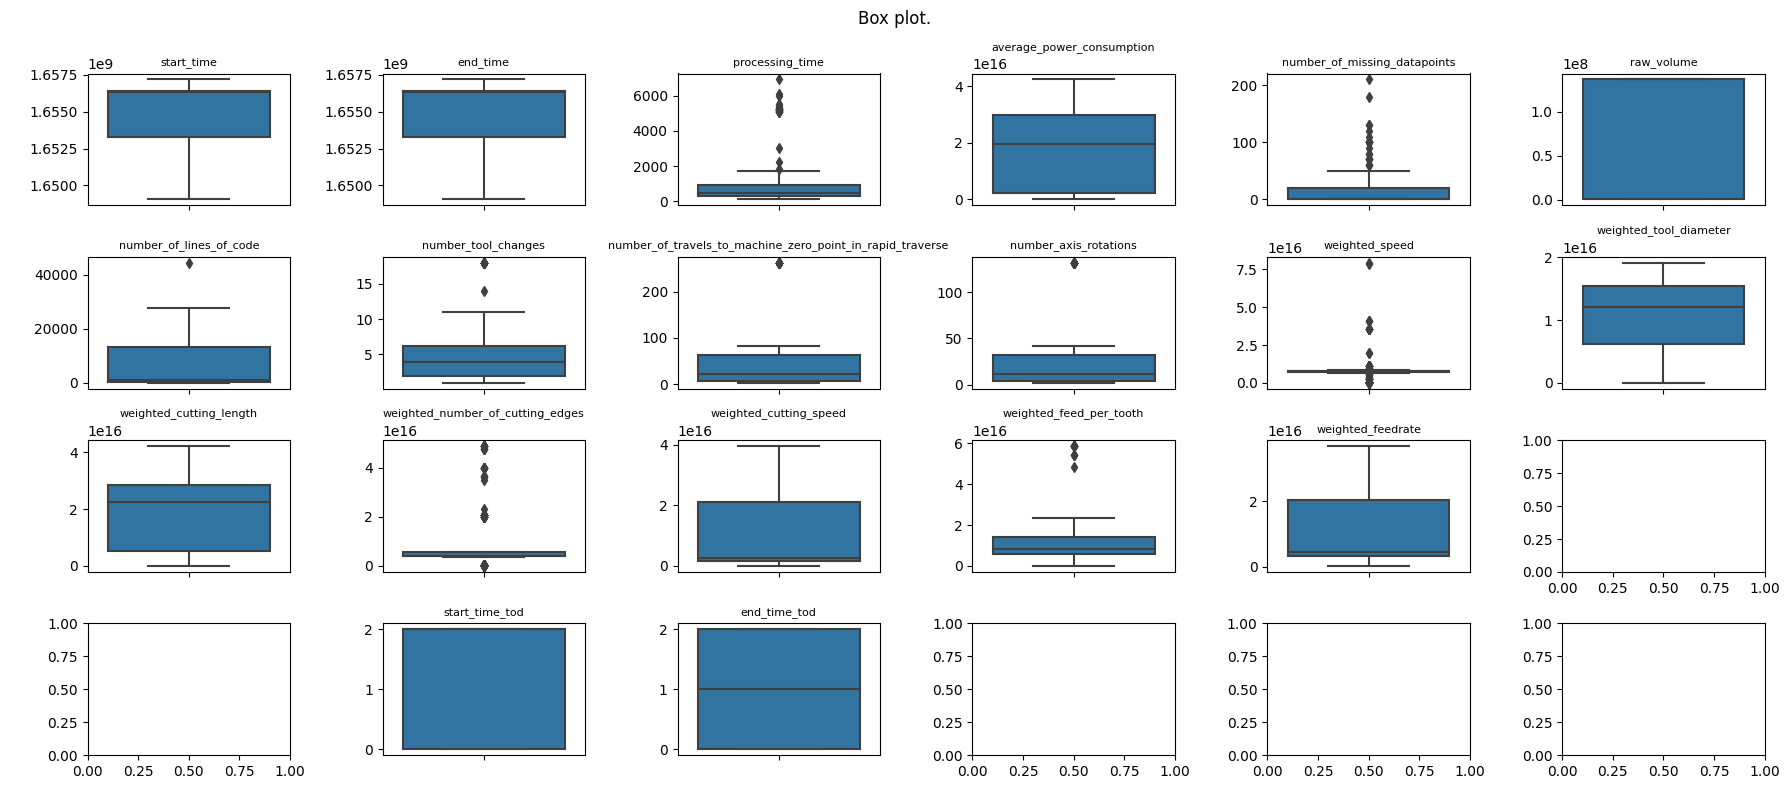

In [17]:
df_plot = df_cnc_encoded.copy()
row_num = 4
col_num = math.ceil(len(df_plot.columns)/row_num)
column_list = coolReshape(df_plot.columns.to_list(), row_num, col_num)

fig, axe = plt.subplots(row_num, col_num, figsize=(col_num*3,row_num*2))
fig.suptitle('Box plot.')
for i, row in enumerate(column_list):
    for j, column in enumerate(row):
        try:
            sns.boxplot(data=df_plot, y=column, ax=axe[i][j])
            axe[i][j].set_title(column, fontsize=8)
            axe[i][j].set_ylabel(" ")
        except:
            pass
plt.tight_layout()
plt.show()

## 2.4 Distribution

In [18]:
def plotpdf(df, x, axe, bins=15, kde=True, hue=None):
    df_temp = df.copy()
    def annotate(**kws):
        value = distributionValue(df_temp[x])
        bbox = dict(boxstyle="round,pad=0.3", alpha=0.3, fc="white", ec="grey", lw=1)
        annotate_value = (f"STAT\n"
                          f"mean: {humanize.scientific(value['mean'])}\n"
                          f"std: {humanize.scientific(value['std'])}\n"
                          f"skew: {humanize.scientific(value['skewness'])}\n"
                          f"kurt: {humanize.scientific(value['kurtosis'])}")
        #ax = plt.gca()
        if value['skewness'] < 0:
            x_anotate = 0.05
        else:
            x_anotate = 0.65
        axe.annotate(annotate_value, xy=(x_anotate, .45), xycoords=axe.transAxes, fontsize=12, bbox=bbox)

    sns.histplot(df_temp, x=x, kde=kde, ax=axe, bins=bins, hue=hue)
    axe.set_title(x)
    axe.tick_params(axis='x', width=2, length=7, direction='inout', rotation=15, labelsize=12)
    axe.tick_params(axis='y', width=2, length=7, direction='inout', rotation=0, labelsize=12)
    axe.set(xlabel=None)
    axe.set(ylabel=None)
    plt.tight_layout()
    annotate()
    return axe

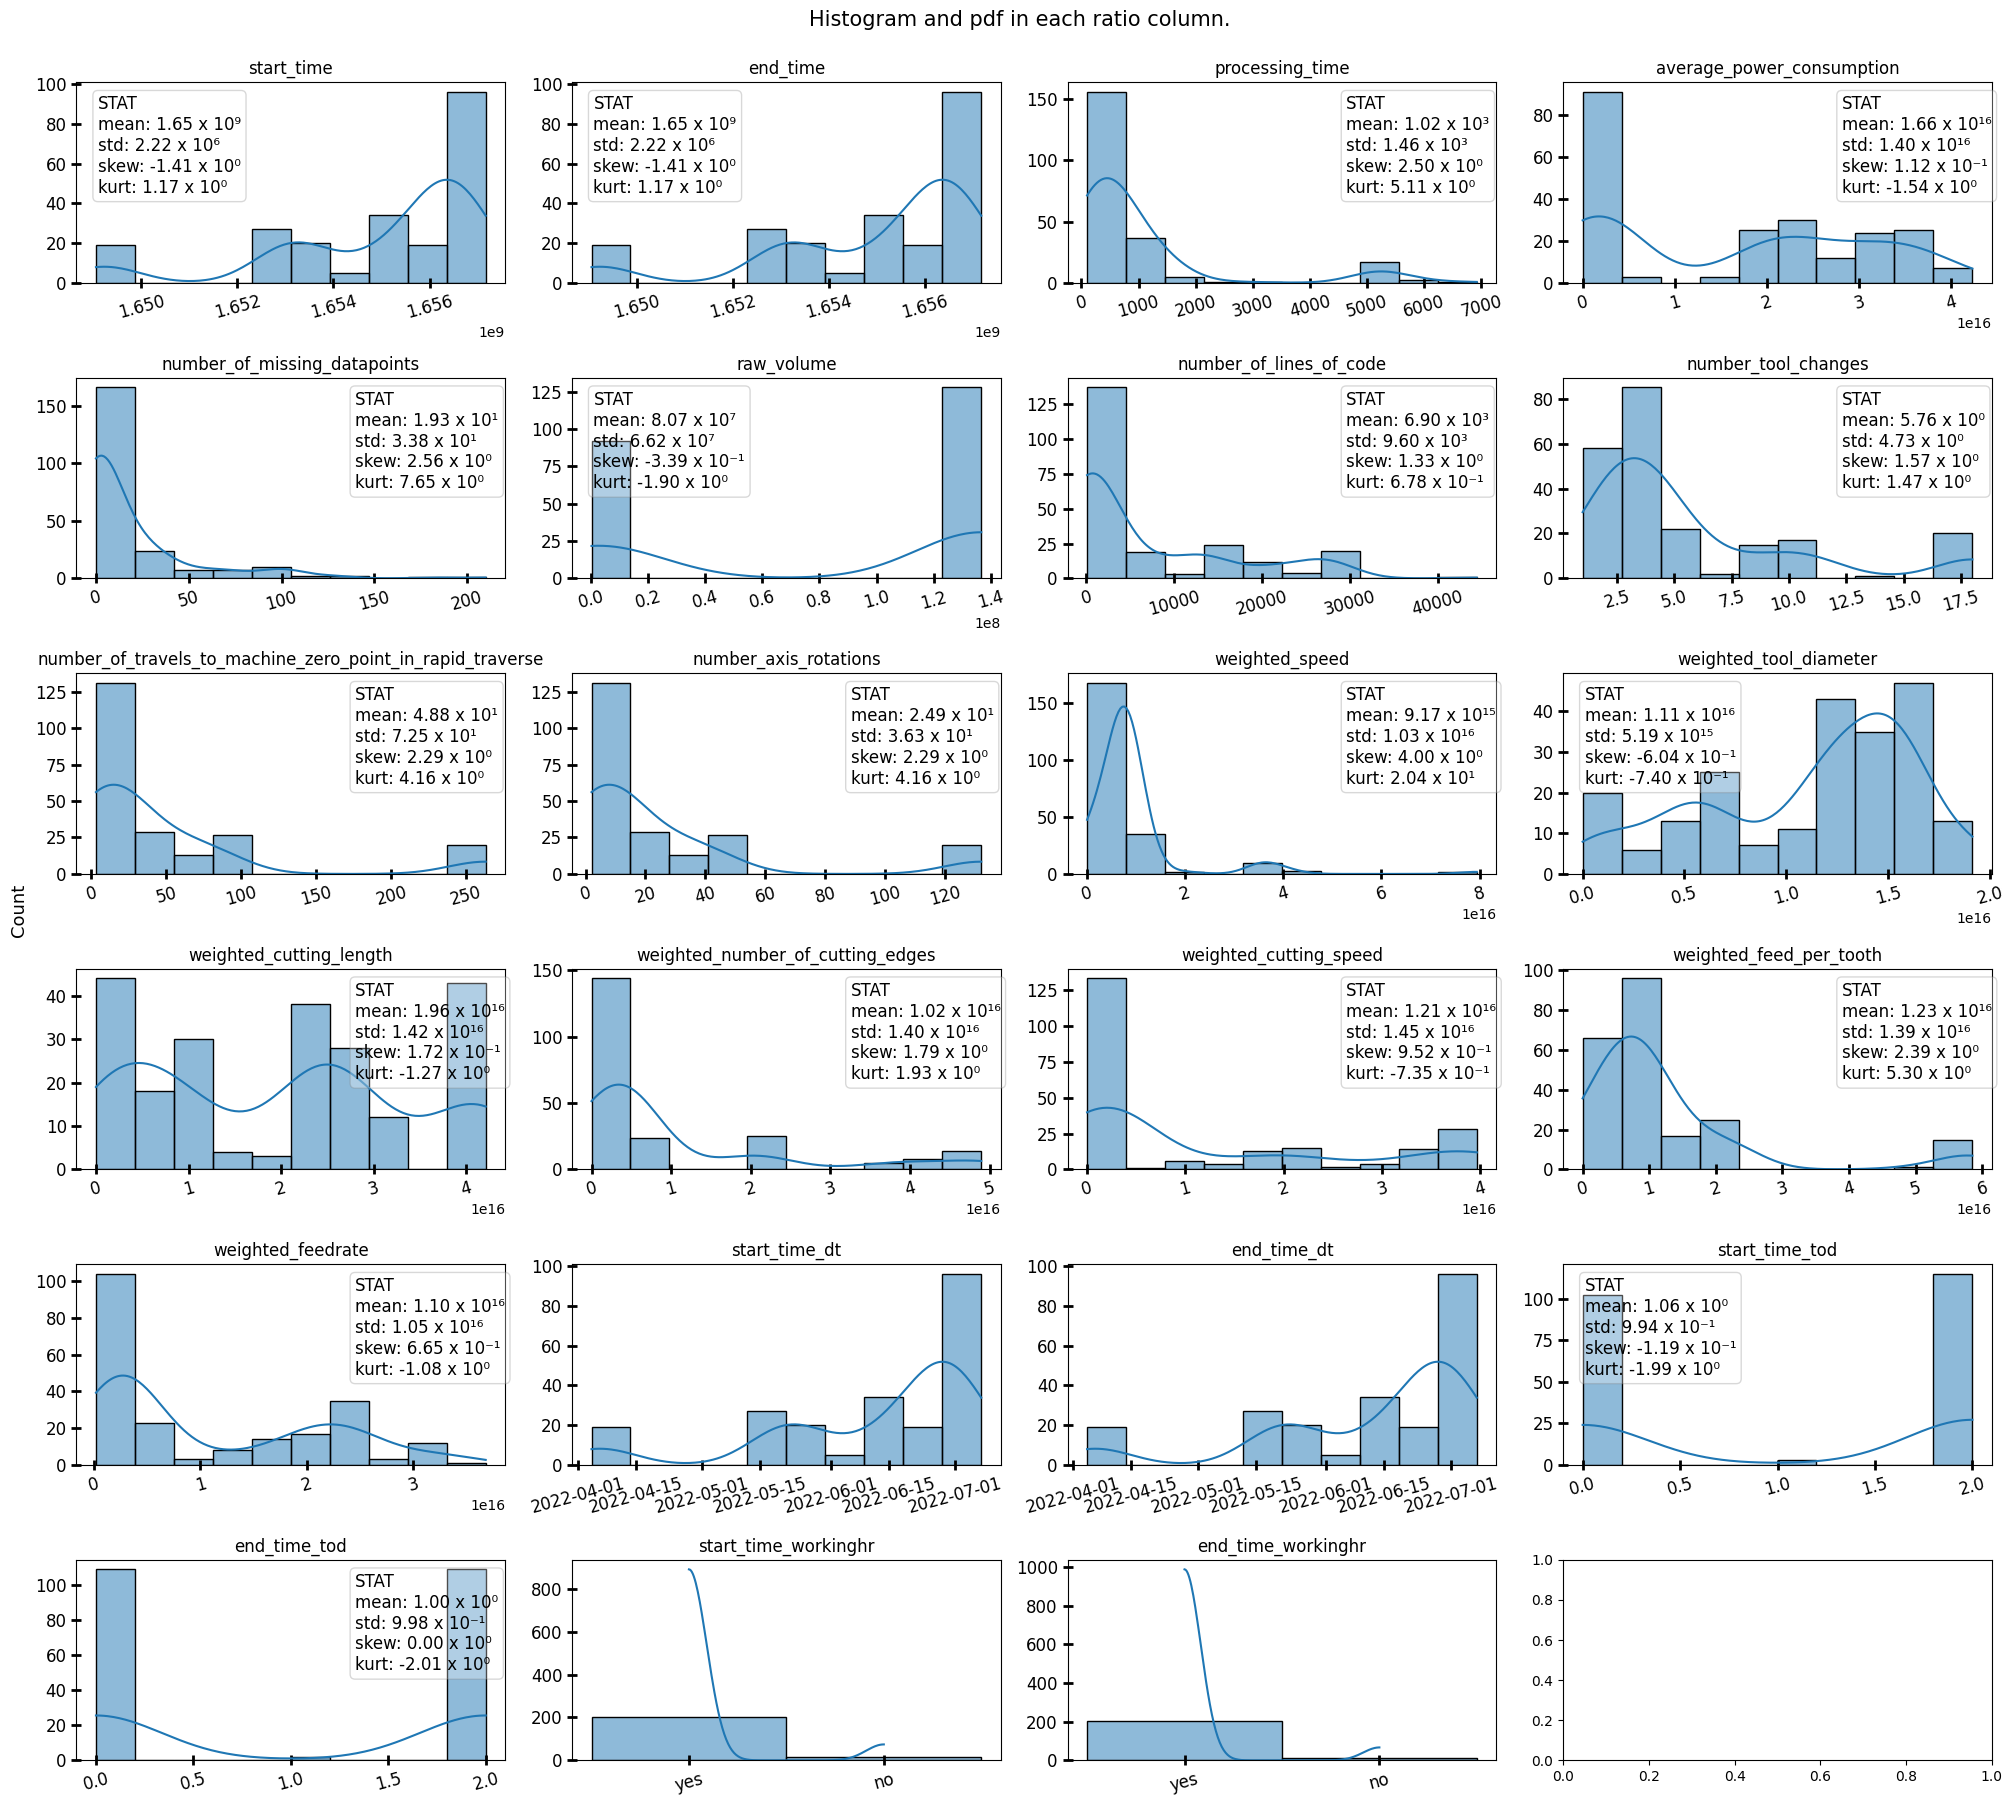

In [19]:
df_plot = df_cnc.copy()
row_num = 6
col_num = math.ceil(len(df_cnc.columns)/row_num)
column_list = coolReshape(df_cnc.columns.to_list(), row_num, col_num)

fig, axe = plt.subplots(row_num, col_num, figsize=(col_num*5,row_num*3))
fig.suptitle('Histogram and pdf in each ratio column.', size=15, y=1)

for i, row in enumerate(column_list):
    for j, column in enumerate(row):
        try:
            plotpdf(df_plot, column, axe[i][j], bins=10)
            axe[i][j].set_title(column, fontsize=12)
        except:
            pass

fig.text(-0.005, 0.500, 'Count', va='center', rotation='vertical', fontsize=13)
# plt.tight_layout()
plt.show()

# 3. Prediction: Processing_Time
## 3.1) Check for missing values

In [20]:
# Find missing values
percent_missing = df_cnc.isnull().sum() * 100 / len(df_cnc)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing}, index=df_cnc.columns)
display(missing_value_df.T)

start_time  end_time  processing_time  \
percent_missing         0.0       0.0              0.0   

                 average_power_consumption  number_of_missing_datapoints  \
percent_missing                        0.0                           0.0   

                 raw_volume  number_of_lines_of_code  number_tool_changes  \
percent_missing         0.0                      0.0                  0.0   

                 number_of_travels_to_machine_zero_point_in_rapid_traverse  \
percent_missing                                                0.0           

                 number_axis_rotations  ...  weighted_number_of_cutting_edges  \
percent_missing                    0.0  ...                               0.0   

                 weighted_cutting_speed  weighted_feed_per_tooth  \
percent_missing                     0.0                      0.0   

                 weighted_feedrate  start_time_dt  end_time_dt  \
percent_missing                0.0            0.0          0.0   

                 start_time_tod  end_time_tod  start_time_workinghr  \
percent_missing             0.0           0.0                   0.0   

                 end_time_workinghr  
percent_missing                 0.0  

[1 rows x 23 columns]

## 3.2 Feature Importance

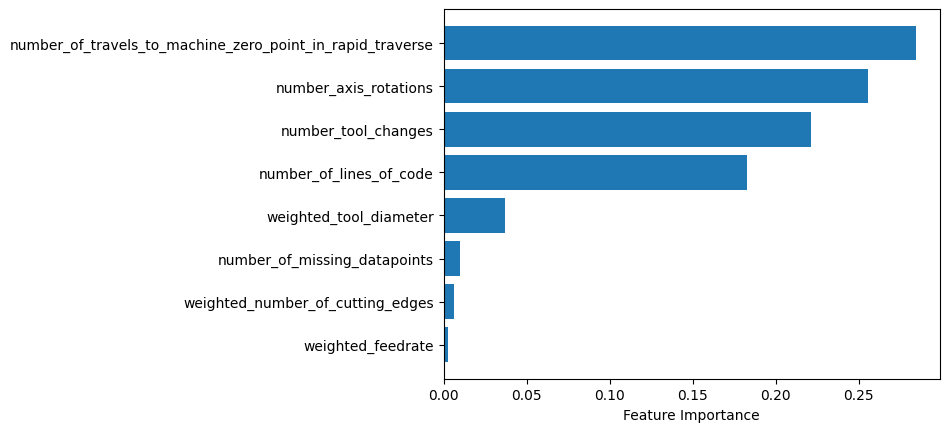

In [21]:
features = ['number_of_travels_to_machine_zero_point_in_rapid_traverse',
            'number_axis_rotations',
            'number_of_missing_datapoints',
            'number_tool_changes',
            'number_of_lines_of_code',
            'weighted_tool_diameter',
            'weighted_number_of_cutting_edges',
            'weighted_feedrate']

target = 'processing_time'

feature_importance(df_cnc, features, target)

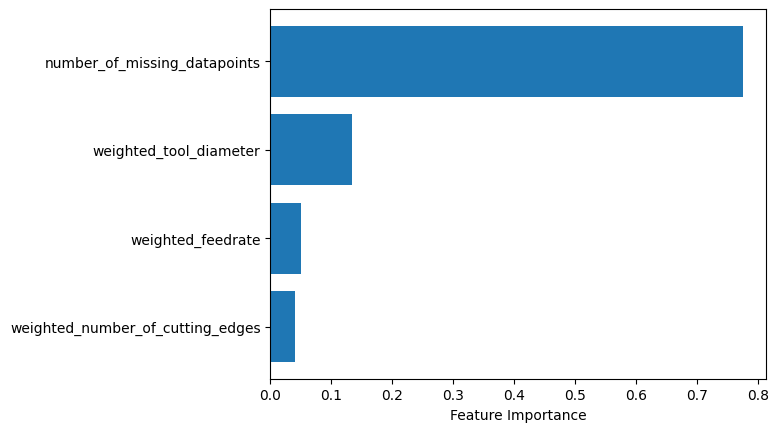

In [22]:
features = ['number_of_missing_datapoints',
            'weighted_tool_diameter',
            'weighted_number_of_cutting_edges',
            'weighted_feedrate']

target = 'processing_time'

feature_importance(df_cnc, features, target)

In [23]:
features = ['number_of_travels_to_machine_zero_point_in_rapid_traverse',
            'number_axis_rotations',
            'number_tool_changes',
            'number_of_lines_of_code']

target = 'processing_time'

## 3.3 Split dataset to train and test datasets

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X = df_cnc[features]
y = df_cnc[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42, stratify=None)

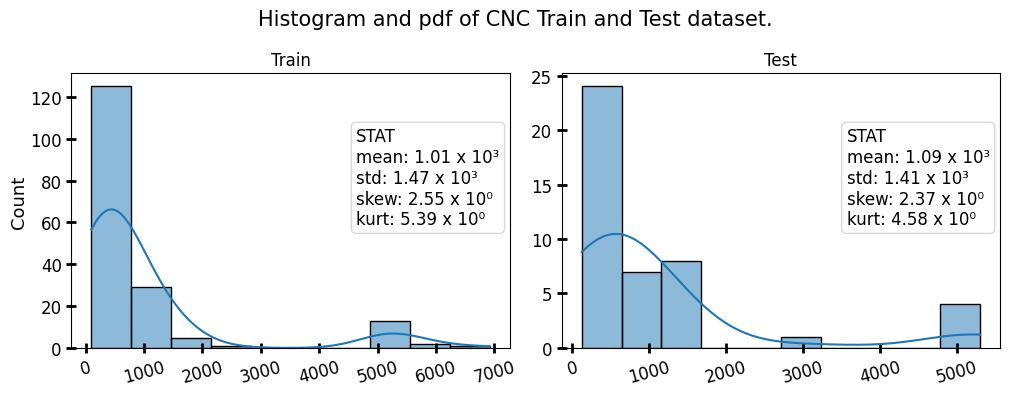

In [26]:
fig, axe = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Histogram and pdf of CNC Train and Test dataset.', size=15)

plotpdf(pd.DataFrame(y_train), 'processing_time', axe[0], bins=10)
plotpdf(pd.DataFrame(y_test), 'processing_time', axe[1], bins=10)
axe[0].set_title('Train')
axe[1].set_title('Test')

fig.text(-0.005, 0.500, 'Count', va='center', rotation='vertical', fontsize=13)
plt.tight_layout(h_pad=1, w_pad=1)
plt.show()

In [27]:
eval_dict = {}

## 3.4 Random Forest Regressor

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=1000, random_state=0))])

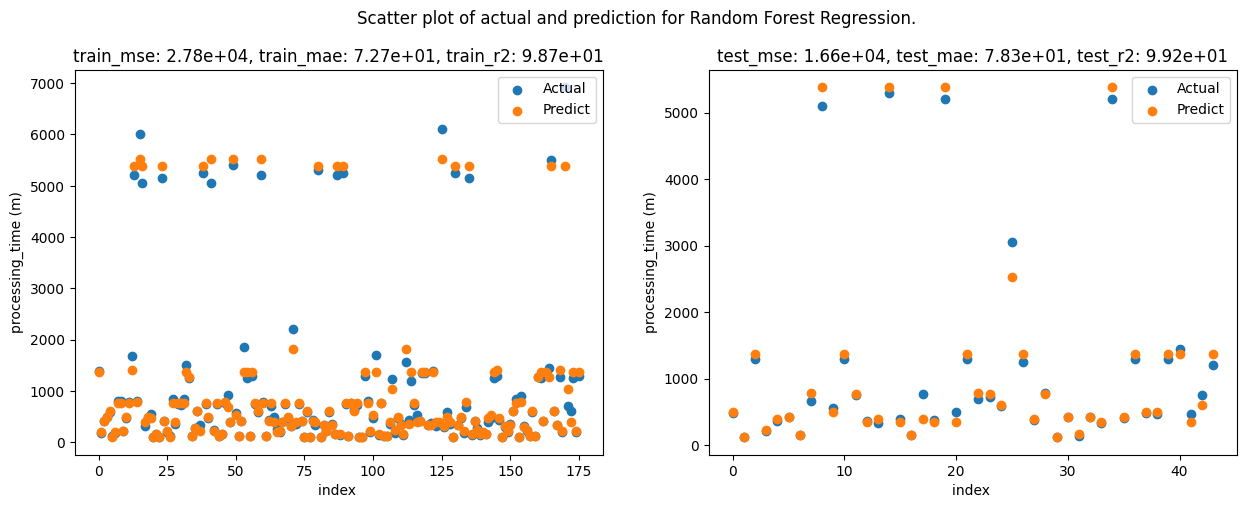

In [28]:
from sklearn.ensemble import RandomForestRegressor

# Create model
model = RandomForestRegressor(max_depth=1000, random_state=0)
predict = prediction_regression(model, X_train, X_test, y_train, y_test)

# Evaluation
predict.eval(eval_dict, 'Random Forest')

# Show prediction pipline
display(predict.pipe)

# Plot
fig, axe = predict.plot(y_unit='(m)')
fig.suptitle("Scatter plot of actual and prediction for Random Forest Regression.", y=1)
plt.show()

## 3.5 Polynomial Regression

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

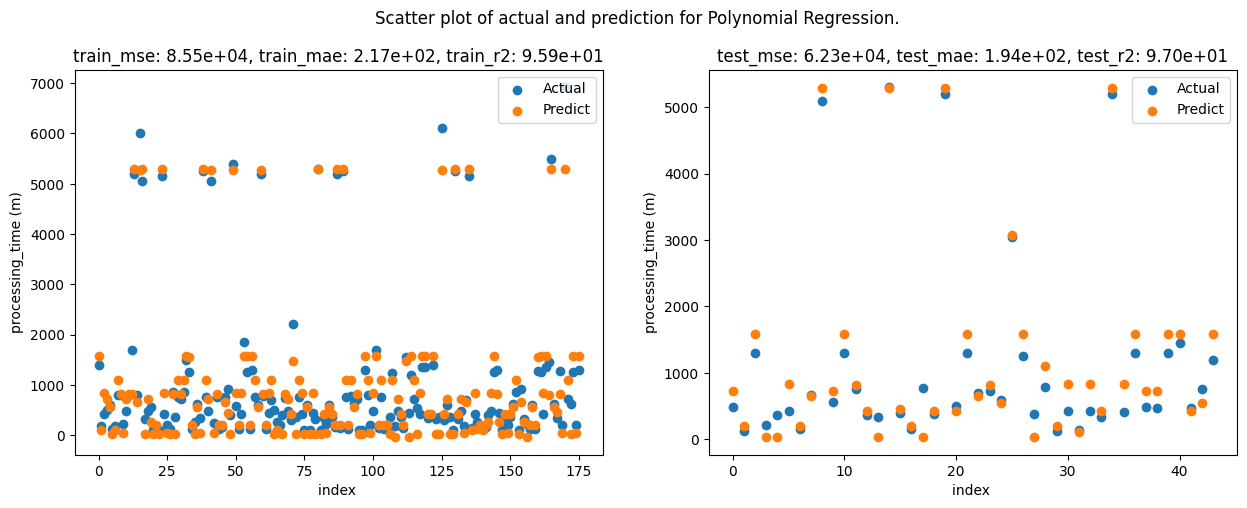

In [29]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Create model
poly_reg = PolynomialFeatures(degree = 2)
X_temp = X
X_poly = poly_reg.fit_transform(X_temp)
X_train_pol, X_test_pol, y_train_pol, y_test_pol = train_test_split(X_temp, y, test_size = 0.20, random_state = 42, stratify=None)
poly_reg.fit(X_train_pol, y_train_pol)

# Create model
model = LinearRegression()
predict = prediction_regression(model, X_train_pol, X_test_pol, y_train_pol, y_test_pol)

# Show prediction pipline
display(predict.pipe)

# Evaluation
predict.eval(eval_dict, 'Polynomial Regression')

# Plot
fig, axe = predict.plot(y_unit='(m)')
fig.suptitle("Scatter plot of actual and prediction for Polynomial Regression.", y=1)
plt.show()

## 3.6 XGBoost

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=0.5, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='', learning_rate=0.01,
                              max_bin=256, max_cat_threshold=64,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=1000, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, ...))])

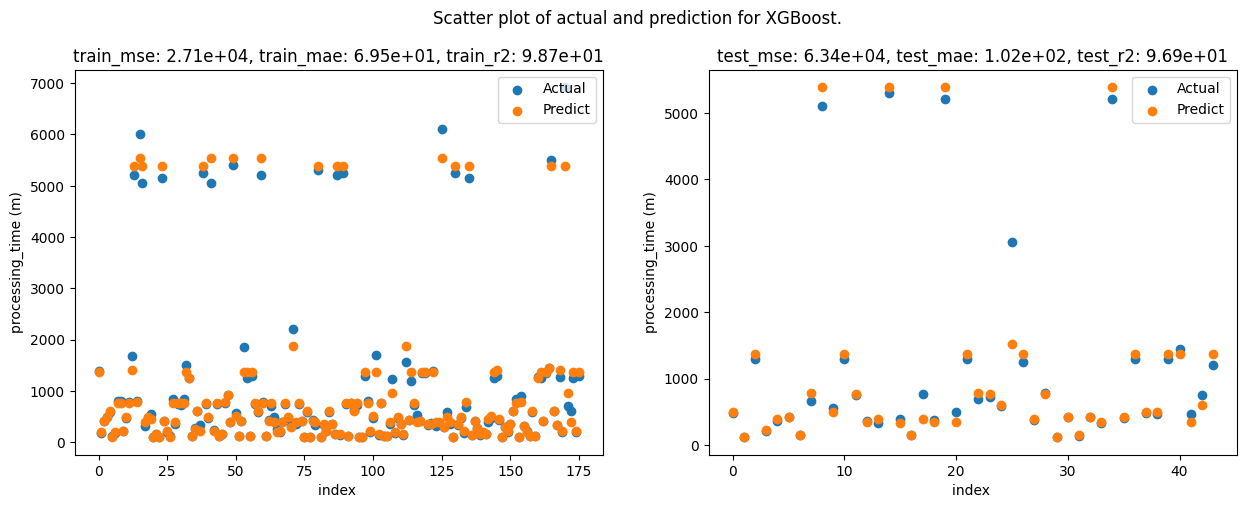

In [30]:
import xgboost as xgb

# Create model
model = xgb.XGBRegressor(
    objective ='reg:squarederror', 
    max_depth = 1000, 
    colsample_bylevel = 0.5,
    learning_rate = 0.01,
    n_estimators = 1000)
predict = prediction_regression(model, X_train, X_test, y_train, y_test)

# Show prediction pipline
display(predict.pipe)

# Evaluation
predict.eval(eval_dict, 'XGBoost')

# Plot
fig, axe = predict.plot(y_unit='(m)')
fig.suptitle("Scatter plot of actual and prediction for XGBoost.", y=1)
plt.show()

## 3.7 SVM 

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', SVC(degree=2, random_state=0))])

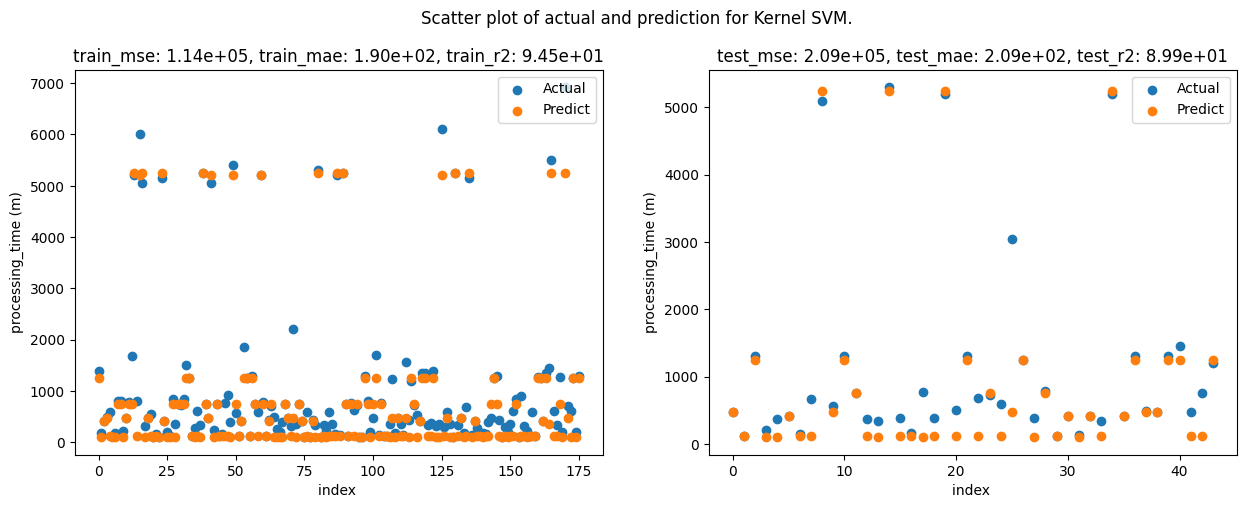

In [31]:
from sklearn.svm import SVC
from sklearn.svm import SVR

# Create Model
model = SVC(kernel = 'rbf', degree = 2, random_state = 0)
predict = prediction_regression(model, X_train, X_test, y_train, y_test)

# Show prediction pipline
display(predict.pipe)

# Evaluation
predict.eval(eval_dict, 'Kernel SVM')

# Plot
fig, axe = predict.plot(y_unit='(m)')
fig.suptitle("Scatter plot of actual and prediction for Kernel SVM.", y=1)
plt.show()

## 3.8 Decision Tree Regression

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', DecisionTreeRegressor(min_samples_leaf=4))])

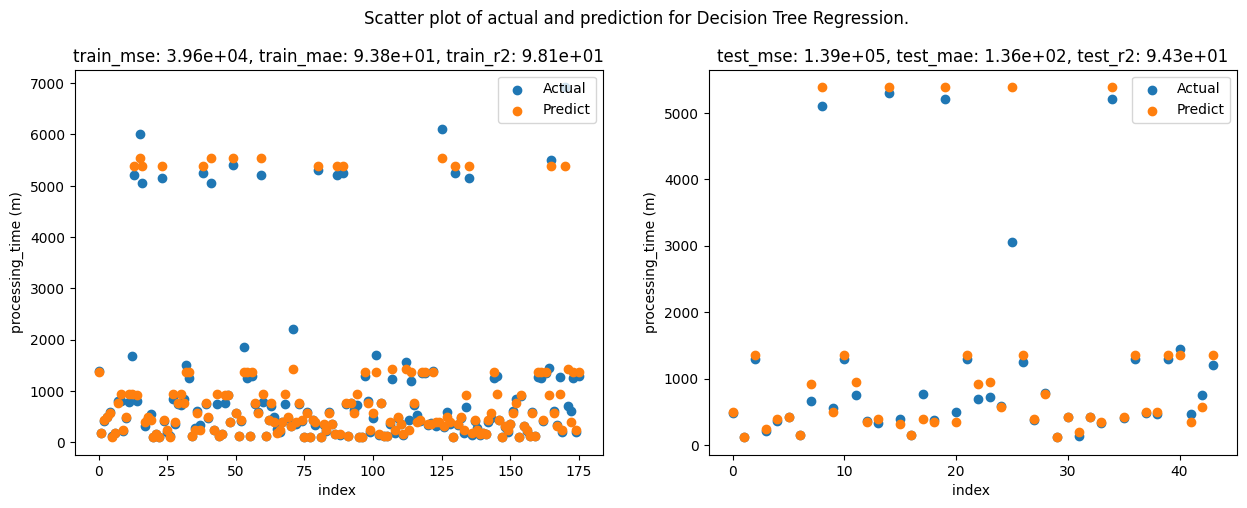

In [32]:
from sklearn.tree import DecisionTreeRegressor

# Create model
model = DecisionTreeRegressor(min_samples_leaf=4)
predict = prediction_regression(model, X_train, X_test, y_train, y_test)

# Show prediction pipline
display(predict.pipe)

# Evaluation
predict.eval(eval_dict, 'Decision Tree Regression')

# Plot
fig, axe = predict.plot(y_unit='(m)')
fig.suptitle("Scatter plot of actual and prediction for Decision Tree Regression.", y=1)
plt.show()


## 3.9 K-Nearest Neighbors Regression

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsRegressor(algorithm='ball_tree', n_neighbors=2))])

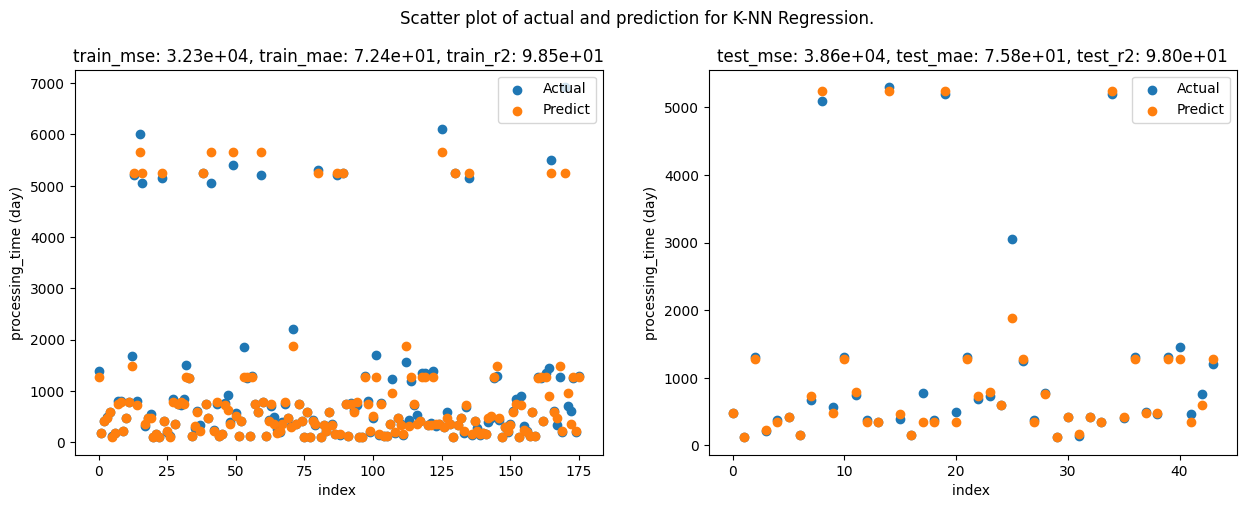

In [33]:
from sklearn.neighbors import KNeighborsRegressor

# Create model
model = KNeighborsRegressor(
    n_neighbors=2, 
    algorithm='ball_tree')
predict = prediction_regression(model, X_train, X_test, y_train, y_test)

# Show prediction pipline
display(predict.pipe)

# Evaluation
predict.eval(eval_dict, 'KNN')

# Plot
fig, axe = predict.plot(y_unit='(day)')
fig.suptitle("Scatter plot of actual and prediction for K-NN Regression.", y=1)
plt.show()

## 3.10 Plot the metrics

In [34]:
df_plot = pd.DataFrame(eval_dict).T
display(df_plot)

train_mse   train_mae   train_r2       test_mse  \
Random Forest              27792.299617   72.715372  98.687685   16608.605474   
Polynomial Regression      85513.786119  216.948756  95.868555   62283.533776   
XGBoost                    27091.770673   69.487221  98.726621   63419.832305   
Kernel SVM                113819.460227  190.426136  94.513548  209081.818182   
Decision Tree Regression   39649.625326   93.781277  98.125926  138597.296745   
KNN                        32285.333807   72.372159  98.451720   38613.068182   

                            test_mae    test_r2  
Random Forest              78.260527  99.196412  
Polynomial Regression     194.104244  96.968456  
XGBoost                   102.002006  96.873399  
Kernel SVM                208.636364  89.880230  
Decision Tree Regression  136.020963  94.285828  
KNN                        75.795455  98.001522

In [35]:
df_plot['train_mse'] = convertToPercentage(df_plot,'train_mse')
df_plot['train_mae'] = convertToPercentage(df_plot,'train_mae')
df_plot['test_mse'] = convertToPercentage(df_plot,'test_mse')
df_plot['test_mae'] = convertToPercentage(df_plot,'test_mae')
df_plot.sort_values(by='test_r2', ascending=False, inplace=True)
display(df_plot)

train_mse  train_mae   train_r2   test_mse  \
Random Forest              8.521264  10.160035  98.687685   3.141974   
KNN                        9.898852  10.112080  98.451720   7.304722   
Polynomial Regression     26.218974  30.312806  95.868555  11.782641   
XGBoost                    8.306478   9.708987  98.726621  11.997603   
Decision Tree Regression  12.156782  13.103434  98.125926  26.219485   
Kernel SVM                34.897641  26.606977  94.513548  39.553567   

                           test_mae    test_r2  
Random Forest              9.846569  99.196412  
KNN                        9.536419  98.001522  
Polynomial Regression     24.421772  96.968456  
XGBoost                   12.833670  96.873399  
Decision Tree Regression  17.113860  94.285828  
Kernel SVM                26.250172  89.880230

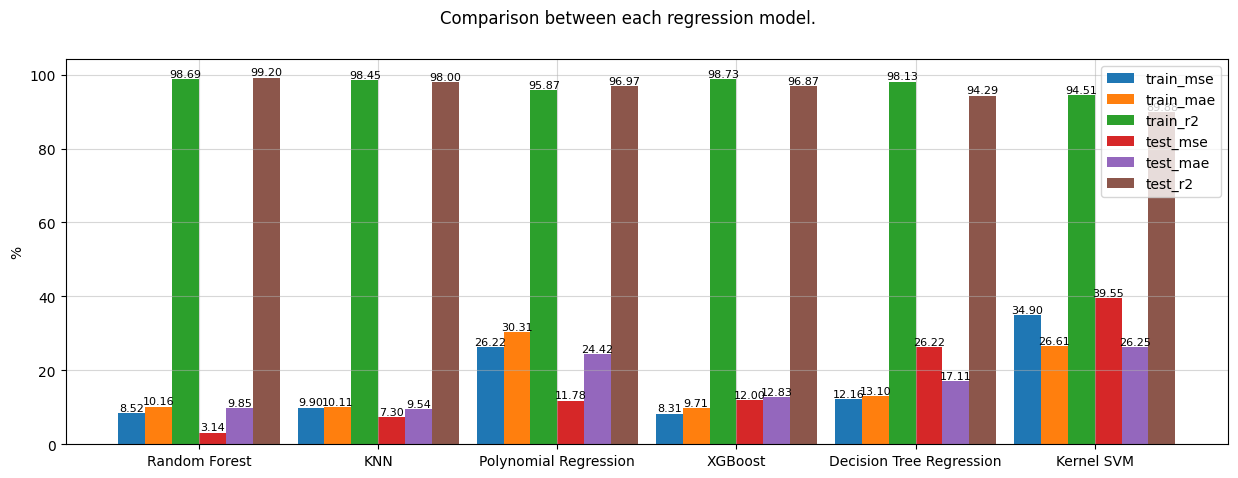

In [36]:
fig, axe = plotMetric(df_plot, width = 0.15)
fig.suptitle('Comparison between each regression model.')
axe.set_ylabel('%')
plt.show()

# 4. Prediction: Average Power Consumption

## 4.1 Feature Importance

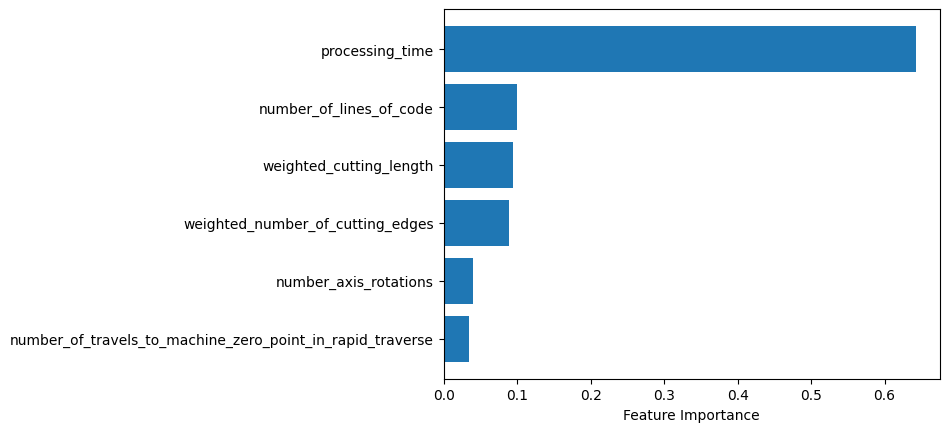

In [52]:
features = ['number_of_travels_to_machine_zero_point_in_rapid_traverse',
'number_axis_rotations',
'weighted_cutting_length',
'processing_time',
'number_of_lines_of_code',
'weighted_number_of_cutting_edges']

target = 'average_power_consumption'

feature_importance(df_cnc, features, target)

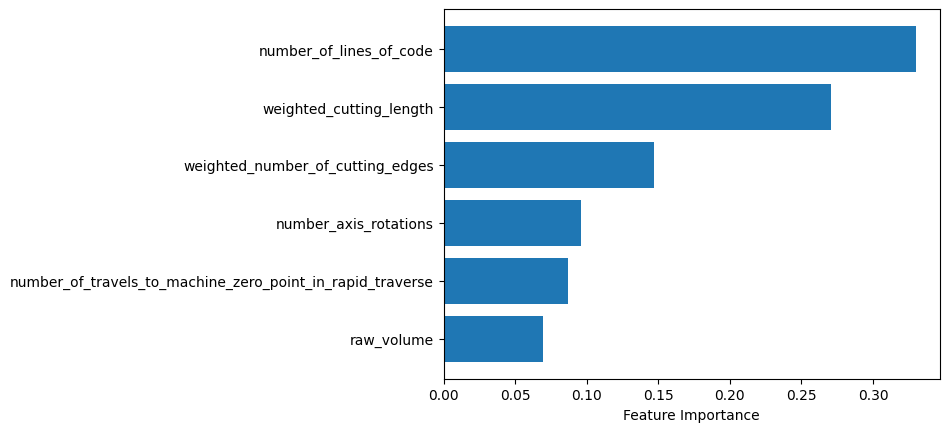

In [53]:
features = ['number_of_travels_to_machine_zero_point_in_rapid_traverse',
'number_axis_rotations',
'weighted_cutting_length',
'number_of_lines_of_code',
'weighted_number_of_cutting_edges',
'raw_volume']

target = 'average_power_consumption'

feature_importance(df_cnc, features, target)

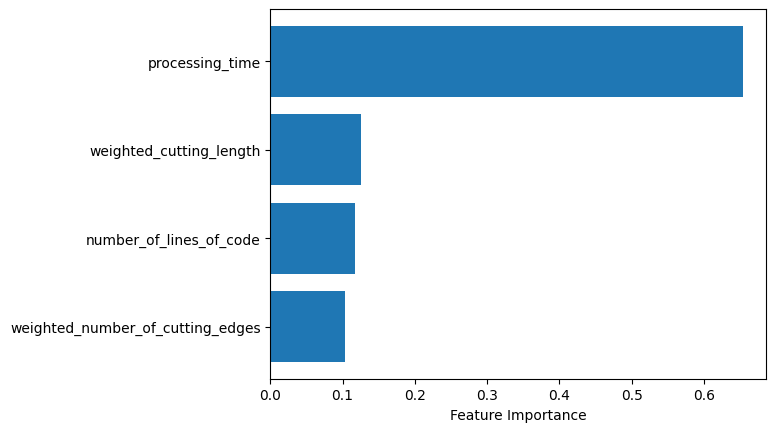

In [54]:
features = [
'processing_time',
'weighted_cutting_length',
'number_of_lines_of_code',
'weighted_number_of_cutting_edges'
]

target = 'average_power_consumption'

feature_importance(df_cnc, features, target)

## 4.2 Split dataset to train and test datasets

In [55]:
X = df_cnc[features]
y = df_cnc[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42, stratify=None)

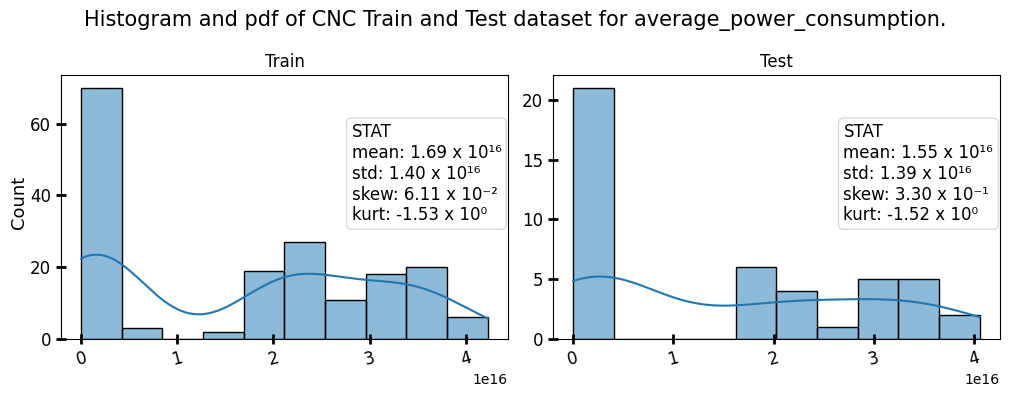

In [56]:
fig, axe = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Histogram and pdf of CNC Train and Test dataset for average_power_consumption.', size=15)

plotpdf(pd.DataFrame(y_train), 'average_power_consumption', axe[0], bins=10)
plotpdf(pd.DataFrame(y_test), 'average_power_consumption', axe[1], bins=10)
axe[0].set_title('Train')
axe[1].set_title('Test')

fig.text(-0.005, 0.500, 'Count', va='center', rotation='vertical', fontsize=13)
plt.tight_layout(h_pad=1, w_pad=1)
plt.show()

In [57]:
eval_dict2 = {}

## 4.3 Random Forest Regressor

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=1000, random_state=0))])

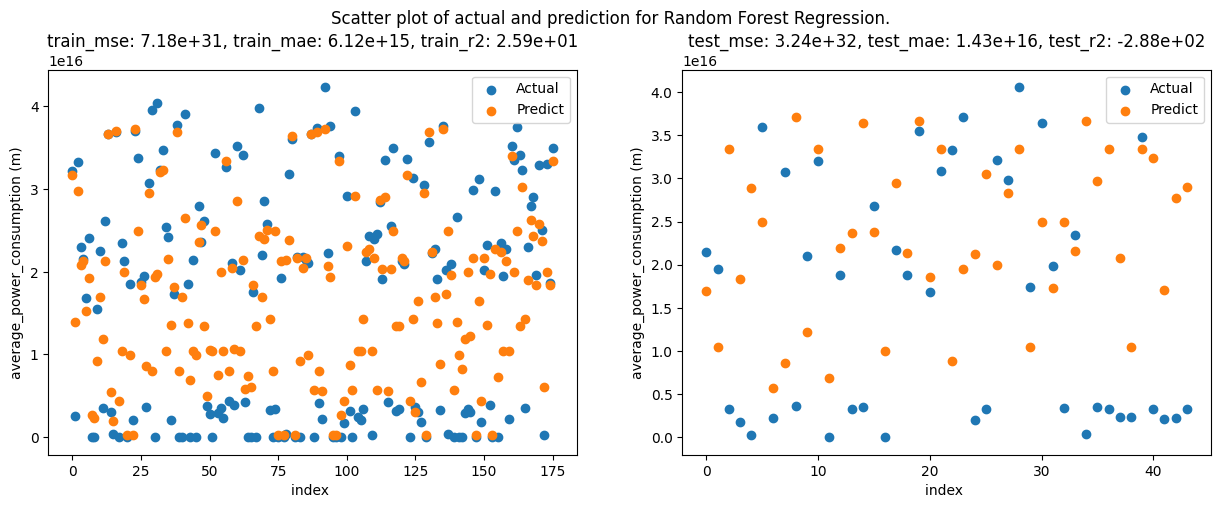

In [58]:
from sklearn.ensemble import RandomForestRegressor

# Create model
model = RandomForestRegressor(max_depth=1000, random_state=0)
predict = prediction_regression(model, X_train, X_test, y_train, y_test)

# Show prediction pipline
display(predict.pipe)

# Evaluation
predict.eval(eval_dict2, 'Random Forest')

# Plot
fig, axe = predict.plot(y_unit='(m)')
fig.suptitle("Scatter plot of actual and prediction for Random Forest Regression.", y=1)
plt.show()

## 4.4 Polynomial Regression

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

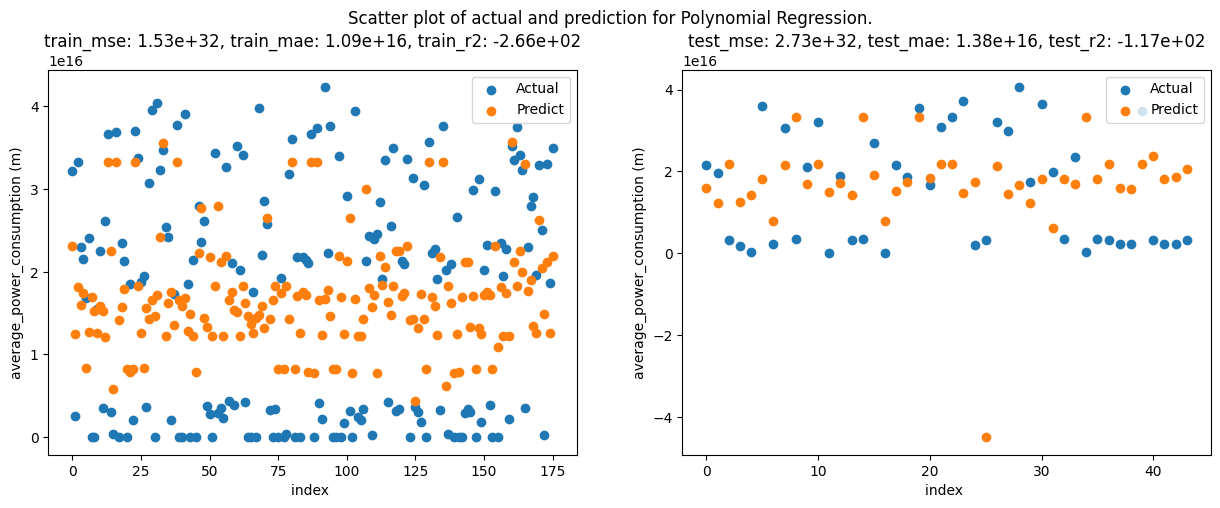

In [59]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Create Polynomial Function
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(np.array(X_train))
X_test_poly = poly.fit_transform(np.array(X_test))

# Create model
model = LinearRegression()
predict = prediction_regression(model, X_train_poly, X_test_poly, y_train, y_test)

# Show prediction pipline
display(predict.pipe)

# Evaluation
predict.eval(eval_dict, 'Polynomial')

# Plot
fig, axe = predict.plot(y_unit='(m)')
fig.suptitle("Scatter plot of actual and prediction for Polynomial Regression.", y=1)
plt.show()

## 4.5 XGBoost

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=0.5, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='', learning_rate=0.01,
                              max_bin=256, max_cat_threshold=64,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=1000, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, ...))])

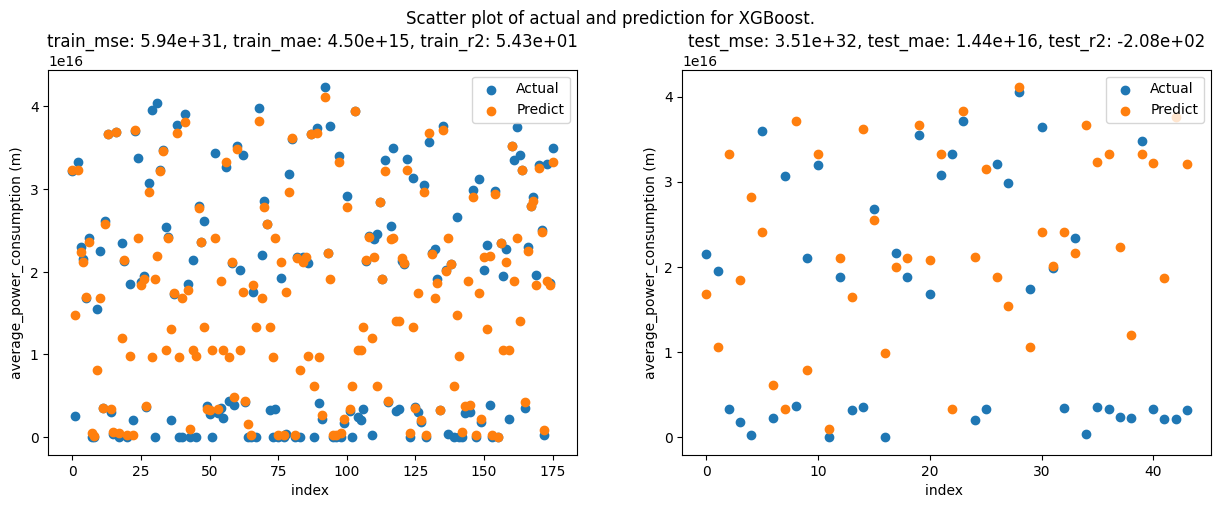

In [60]:
import xgboost as xgb

# Create model
model = xgb.XGBRegressor(
    objective ='reg:squarederror', 
    max_depth = 1000, 
    colsample_bylevel = 0.5,
    learning_rate = 0.01,
    n_estimators = 1000)
predict = prediction_regression(model, X_train, X_test, y_train, y_test)

# Show prediction pipline
display(predict.pipe)

# Evaluation
predict.eval(eval_dict2, 'XGBoost')

# Plot
fig, axe = predict.plot(y_unit='(m)')
fig.suptitle("Scatter plot of actual and prediction for XGBoost.", y=1)
plt.show()

## 4.6 Decision Tree Regression

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', DecisionTreeRegressor(min_samples_leaf=4))])

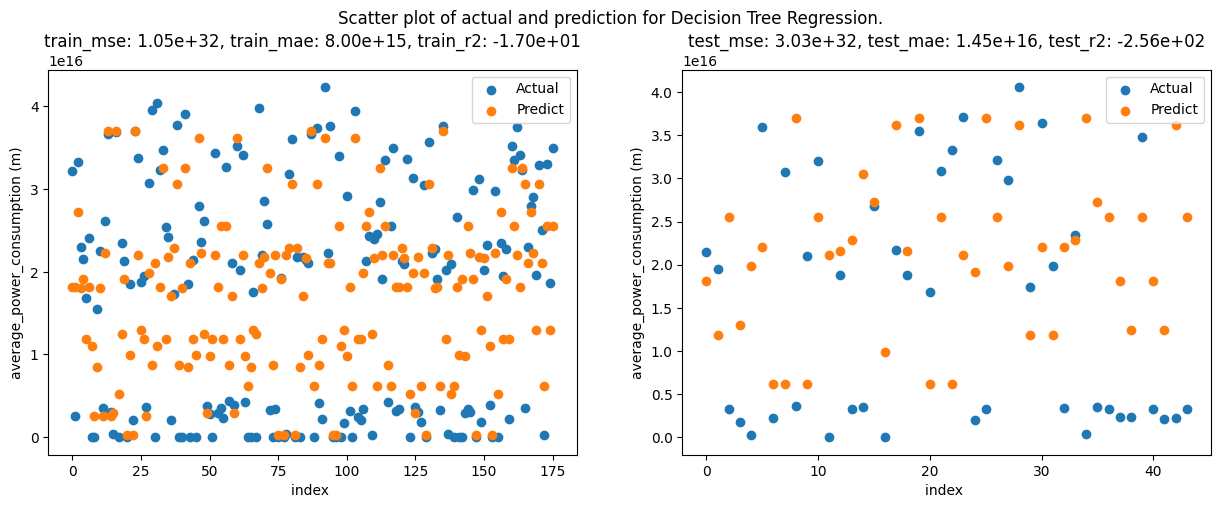

In [61]:
from sklearn.tree import DecisionTreeRegressor

# Create model
model = DecisionTreeRegressor(min_samples_leaf  = 4)
predict = prediction_regression(model, X_train, X_test, y_train, y_test)

# Show prediction pipline
display(predict.pipe)

# Evaluation
predict.eval(eval_dict2, 'Decision Tree Regression')

# Plot
fig, axe = predict.plot(y_unit='(m)')
fig.suptitle("Scatter plot of actual and prediction for Decision Tree Regression.", y=1)
plt.show()

## 4.7 K-Nearest Neighbors Regression

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsRegressor(algorithm='ball_tree', n_neighbors=2))])

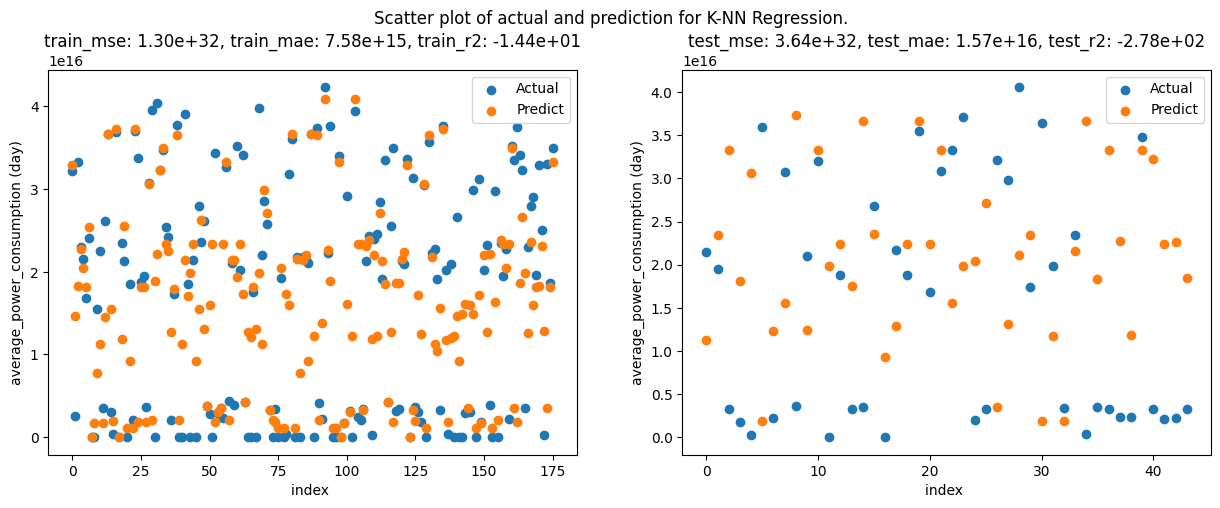

In [62]:
from sklearn.neighbors import KNeighborsRegressor

# Create model
model = KNeighborsRegressor(
    n_neighbors=2, 
    algorithm='ball_tree')
predict = prediction_regression(model, X_train, X_test, y_train, y_test)

# Show prediction pipline
display(predict.pipe)

# Evaluation
predict.eval(eval_dict2, 'KNN')

# Plot
fig, axe = predict.plot(y_unit='(day)')
fig.suptitle("Scatter plot of actual and prediction for K-NN Regression.", y=1)
plt.show()

## 4.8 Plot the metrics

In [65]:
df_plot = pd.DataFrame(eval_dict2).T
display(df_plot)

train_mse     train_mae   train_r2      test_mse  \
Random Forest             7.175221e+31  6.121505e+15  25.903671  3.238786e+32   
XGBoost                   5.935962e+31  4.496152e+15  54.327922  3.510390e+32   
Decision Tree Regression  1.053390e+32  7.996726e+15 -16.982553  3.029674e+32   
KNN                       1.300505e+32  7.581807e+15 -14.378923  3.635481e+32   

                              test_mae     test_r2  
Random Forest             1.434849e+16 -287.886140  
XGBoost                   1.444484e+16 -208.392734  
Decision Tree Regression  1.449628e+16 -256.322053  
KNN                       1.569505e+16 -278.393111

In [66]:
df_plot['train_mse'] = convertToPercentage(df_plot,'train_mse')
df_plot['train_mae'] = convertToPercentage(df_plot,'train_mae')
df_plot['test_mse'] = convertToPercentage(df_plot,'test_mse')
df_plot['test_mae'] = convertToPercentage(df_plot,'test_mae')
df_plot.sort_values(by='test_r2', ascending=False, inplace=True)
df_plot

train_mse  train_mae   train_r2   test_mse  \
XGBoost                   16.196292  17.163382  54.327922  26.168954   
Decision Tree Regression  28.741781  30.526294 -16.982553  22.585354   
KNN                       35.484314  28.942402 -14.378923  27.101472   
Random Forest             19.577613  23.367921  25.903671  24.144220   

                           test_mae     test_r2  
XGBoost                   24.489149 -208.392734  
Decision Tree Regression  24.576355 -256.322053  
KNN                       26.608694 -278.393111  
Random Forest             24.325801 -287.886140

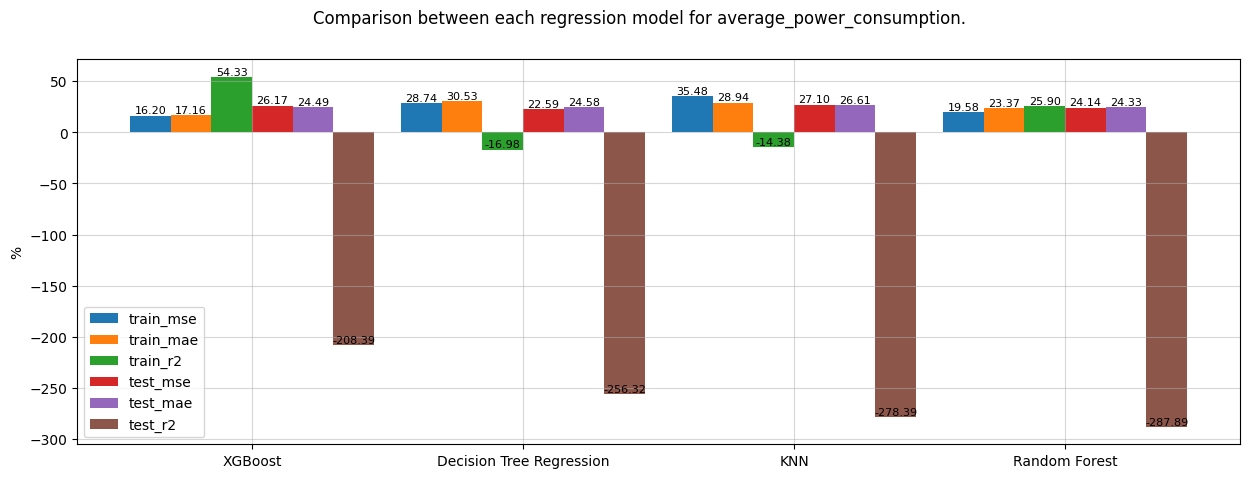

In [67]:
fig, axe = plotMetric(df_plot, width = 0.15)
fig.suptitle('Comparison between each regression model for average_power_consumption.')
axe.set_ylabel('%')
plt.show()